# One Genre To Rule Them All... Globally

We're going to analyze the worldwide box office returns of movies based on their genre.

This is the second step in our analysis. The first step was only considering the domestic market and can be found in the `Domestic.ipynb` notebook. 

To recap our findings there:
  - `Horror` is the safest genre to invest in. It's production budget is much lower than spectacle genres, and it has a higher chance of profitability on a per movie basis.
  - `Action` and `Adventure` are the riskiest genres. They're more expensive, and more often than not, they do not breakeven.
  
It's time now to see what the addition of the worldwide market does to our study!

# The Worldwide Market

It's difficult to pin down exact totals for the domestic versus worldwide box office, but it's clear with each passing year, more and more of a movie's gross comes from abroad.

[Statista](https://www.statista.com/) has 2018 totals being \\$11.9 billion for the [domestic market](https://www.statista.com/statistics/243180/leading-box-office-markets-workdwide-by-revenue/) and \\$29.2 billion for the [international market](https://www.statista.com/statistics/271856/global-box-office-revenue/).

That puts the total box office ratio at 29% domestic and 71% international.

We will use the same approach as our domestic analysis:
- Decide which genres to consider in our analysis.
 
- Decide on a profitability measure.

- Whittle our dataset down to movies released by the Big Five. This is to control for factors like lack of budget or marketing affecting a movie's success. Sure, independent movies can succeed, but our bosses want to see how the genres performed with all the help of a studio behind them.

- Analyze the historical performance of the genres by decade. There might be some trends over time that would be useful to know.

- Analyze the historical performance of the genres by release week. Maybe certain genres perform better at certain times of year.

- Incorporate our findings into a strategy for our bosses!

# Deciding on Genres

According to [The Numbers](https://www.the-numbers.com/market/), the top six genres in terms of box office gross are:
- Adventure
- Action
- Drama
- Comedy
- Thriller/Suspense
- Horror

Our bosses like making money.

Sold.

# Is This Movie Profitable? 

The box office share a studio makes from international sales varies incredibly from country to country.

An article on [Gizmodo](https://io9.gizmodo.com/how-much-money-does-a-movie-need-to-make-to-be-profitab-5747305) claims that a good rule of thumb is that a movie breaks even when it earns twice its production budget worldwide. 

## Profitability equation

We will include marketing costs when calculating the breakeven point. These numbers vary greatly from movie to movie, so we will again assume a 50% spend, pegged to each movie's production budget.   

**Worldwide box office = 2 * 1.5 * Production budget**

So if a movie earns at least three times its original production budget worldwide, it is a winner!

# Curate our dataset

## Import libraries and settings

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

pd.options.display.max_rows = 400
pd.options.display.max_columns = 50

## Import data

In [2]:
data = pd.read_csv('cleaned_movie_data.csv', parse_dates=['release_date'], usecols=['title', 'distributor_mojo', 'worldwide_adj', 'budget_adj',  'genres_mojo', 'release_year', 'release_week', 'release_date'])

# Only look at movies that made money domestically
data = data[data['worldwide_adj'].notna() & data['worldwide_adj'] > 0]

# For decade analysis
data['release_decade'] = data['release_year'].apply(lambda x: x // 10 * 10)

# For breakeven analysis
data['worldwide_breakeven'] = data['worldwide_adj'] >= 3 * data['budget_adj']

# Create columns for genres
# A movie can have multiple genres. If so, we will count them for all the genres its classified with.
data['action'] = data['genres_mojo'].str.contains('Action', na=False)
data['adventure'] = data['genres_mojo'].str.contains('Adventure', na=False) 
data['comedy'] = data['genres_mojo'].str.contains('Comedy', na=False)
data['drama'] = data['genres_mojo'].str.contains('Drama', na=False)
data['horror'] = data['genres_mojo'].str.contains('Horror', na=False)
data['thriller_suspense'] = data['genres_mojo'].str.contains('Thriller|Suspense', na=False, regex=True)

# Remove rows that don't contain one of our genres
data = data[data['action'] | data['adventure'] | data['comedy'] | data['drama'] | data['horror'] | data['thriller_suspense']]

# Create dataframes for the genres
action = data[data['genres_mojo'].str.contains('Action', na=False)]
adventure = data[data['genres_mojo'].str.contains('Adventure', na=False)] 
comedy = data[data['genres_mojo'].str.contains('Comedy', na=False)]
drama = data[data['genres_mojo'].str.contains('Drama', na=False)]
horror = data[data['genres_mojo'].str.contains('Horror', na=False)]
thriller_suspense = data[data['genres_mojo'].str.contains('Thriller|Suspense', na=False, regex=True)]

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5631 entries, 3 to 19775
Data columns (total 16 columns):
title                  5631 non-null object
release_year           5631 non-null int64
distributor_mojo       5631 non-null object
genres_mojo            5631 non-null object
release_date           5631 non-null datetime64[ns]
worldwide_adj          5631 non-null float64
budget_adj             3749 non-null float64
release_week           5631 non-null int64
release_decade         5631 non-null int64
worldwide_breakeven    5631 non-null bool
action                 5631 non-null bool
adventure              5631 non-null bool
comedy                 5631 non-null bool
drama                  5631 non-null bool
horror                 5631 non-null bool
thriller_suspense      5631 non-null bool
dtypes: bool(7), datetime64[ns](1), float64(2), int64(3), object(3)
memory usage: 478.4+ KB


## Organize By Distributors

The [Big Five](https://en.wikipedia.org/wiki/Major_film_studio#Past) studios we will use in our analysis are:
- Universal
- Paramount
- Warner Bros.
- Disney
- Sony

Studios have come and gone a lot historically. They get bought out by competitors, or go out of business. A lot of messy stuff.

To simplify, we will categorize a movie by its current studio owner. So for example, Disney [recently purchased](https://theweek.com/speedreads/780191/disney-buys-21st-century-fox-713-billion) 20th Century Fox. So we will categorize a 20th Century Fox movie as Disney.

In [4]:
data[data['budget_adj'].notna() & data['distributor_mojo'].notna()]['distributor_mojo'].value_counts()

Universal                           355
Warner Bros.                        346
Fox                                 301
Sony / Columbia                     266
Paramount                           264
Buena Vista                         217
New Line                            122
Miramax                             114
Fox Searchlight                     106
Lionsgate                           104
MGM                                  89
Sony Classics                        81
Sony / Screen Gems                   69
Focus Features                       64
Weinstein Company                    49
Warner Bros. (New Line)              49
IFC                                  46
DreamWorks                           42
Lions Gate                           41
United Artists                       41
Magnolia                             41
Columbia                             41
Roadside Attractions                 35
TriStar                              34
Sony (Revolution)                    30


In [5]:
# Create a regex string to combine movies into their respective distributor
# https://en.wikipedia.org/wiki/Major_film_studio#Past
nbcuniversal = 'Universal|Focus Features|Focus World|Gramercy|Working Title|Big Idea|DreamWorks$|Illumination|Carnival|Mac Guff|United International'

print(data[data['distributor_mojo'].str.contains(nbcuniversal, na=False, regex=True)]['distributor_mojo'].value_counts())
print('Sum:', data[data['distributor_mojo'].str.contains(nbcuniversal, na=False, regex=True)]['distributor_mojo'].value_counts().sum())

Universal                       428
Focus Features                   94
DreamWorks                       43
Gramercy                         13
Focus World                      12
Universal Home Entertainment      1
Name: distributor_mojo, dtype: int64
Sum: 591


In [6]:
viacom = 'Paramount|BET|Comedy Central|MTV|Nickelodeon|Bardel Entertainment|MTV Animation|Nickelodeon Animation Studio|Awesomeness|CMT|Melange|United International Pictures|VH1|Viacom 18 Motion Pictures'

print(data[data['distributor_mojo'].str.contains(viacom, na=False, regex=True)]['distributor_mojo'].value_counts())
print('Sum:', data[data['distributor_mojo'].str.contains(viacom, na=False, regex=True)]['distributor_mojo'].value_counts().sum())

Paramount                 284
Paramount Classics         20
Paramount (DreamWorks)     20
Paramount Vantage          19
Paramount Insurge           2
Name: distributor_mojo, dtype: int64
Sum: 345


In [7]:
warnermedia = 'Warner Bros.|CNN Films|HBO|DC Films|New Line|Cartoon Network Studios|Wang Film Productions|Adult Swim Films|Castle Rock Entertainment|Cinemax|Flagship|Fullscreen|Hello Sunshine|Spyglass'

print(data[data['distributor_mojo'].str.contains(warnermedia, na=False, regex=True)]['distributor_mojo'].value_counts())
print('Sum:', data[data['distributor_mojo'].str.contains(warnermedia, na=False, regex=True)]['distributor_mojo'].value_counts().sum())

Warner Bros.               381
New Line                   139
Warner Bros. (New Line)     51
Name: distributor_mojo, dtype: int64
Sum: 571


In [8]:
disney = 'Walt Disney|^Fox$|Fox Atomic|A&E|Disneynature|ESPN|Fox Searchlight|Hulu|National Geographic|VICE|Fox Family|Lucasfilm|Marvel|The Muppets Studio|UTV Motion Pictures|20th Century Fox Animation|Blue Sky Studios|Lucasfilm Animation|Marvel Animation|Pixar Animation Studios|Buena Vista|Disney|Dragonfly Film Productions|Fox Star Studios|Fox Studios Australia|Kudos Film|New Regency|Patagonik Film Group|Shine Group|Tiger Aspect Productions|Zero Day Fox'

print(data[data['distributor_mojo'].str.contains(disney, na=False, regex=True)]['distributor_mojo'].value_counts())
print('Sum:', data[data['distributor_mojo'].str.contains(disney, na=False, regex=True)]['distributor_mojo'].value_counts().sum())

Fox                                  361
Buena Vista                          244
Fox Searchlight                      138
Fox Atomic                             4
National Geographic Entertainment      3
Disney                                 1
Name: distributor_mojo, dtype: int64
Sum: 751


In [9]:
sony = 'Sony|Columbia|Affirm|Screen Gems|Stage 6|Ghost Corps|Funimation|Madhouse|Manga Entertainment UK|TriStar|Destination Films|Left Bank Pictures|Triumph Films'

print(data[data['distributor_mojo'].str.contains(sony, na=False, regex=True)]['distributor_mojo'].value_counts())
print('Sum:', data[data['distributor_mojo'].str.contains(sony, na=False, regex=True)]['distributor_mojo'].value_counts().sum())

Sony / Columbia        288
Sony Classics          151
Sony / Screen Gems      75
Columbia                44
TriStar                 38
Sony (Revolution)       35
Sony / AFFIRM Films      2
Sony BMG                 1
Name: distributor_mojo, dtype: int64
Sum: 634


In [10]:
data['universal'] = data['distributor_mojo'].str.contains(nbcuniversal, na=False, regex=True)
data['paramount'] = data['distributor_mojo'].str.contains(viacom, na=False, regex=True)
data['warner'] = data['distributor_mojo'].str.contains(warnermedia, na=False, regex=True)
data['disney'] = data['distributor_mojo'].str.contains(disney, na=False, regex=True)
data['sony'] = data['distributor_mojo'].str.contains(sony, na=False, regex=True)
data['distributor'] = np.nan

In [11]:
data.loc[data['universal'], 'distributor'] = 'Universal'
data.loc[data['paramount'], 'distributor'] = 'Paramount'
data.loc[data['warner'], 'distributor'] = 'Warner'
data.loc[data['disney'], 'distributor'] = 'Disney'
data.loc[data['sony'], 'distributor'] = 'Sony'

In [12]:
# We only want to keep rows that have one of the Big Five
data = data[data['distributor'].notna()]

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2892 entries, 20 to 19775
Data columns (total 22 columns):
title                  2892 non-null object
release_year           2892 non-null int64
distributor_mojo       2892 non-null object
genres_mojo            2892 non-null object
release_date           2892 non-null datetime64[ns]
worldwide_adj          2892 non-null float64
budget_adj             2453 non-null float64
release_week           2892 non-null int64
release_decade         2892 non-null int64
worldwide_breakeven    2892 non-null bool
action                 2892 non-null bool
adventure              2892 non-null bool
comedy                 2892 non-null bool
drama                  2892 non-null bool
horror                 2892 non-null bool
thriller_suspense      2892 non-null bool
universal              2892 non-null bool
paramount              2892 non-null bool
warner                 2892 non-null bool
disney                 2892 non-null bool
sony                   289

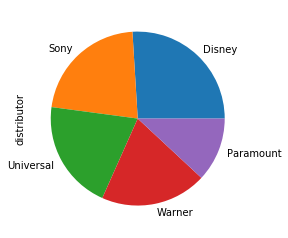

In [100]:
data['distributor'].value_counts().plot(kind='pie');

## Summary

Our filtered dataset now has 2,892 entries. 

The only missing information in our dataframe is in the `budget_adj` column, which is a movie's production budget.

We will just ignore the missing entries when we need the production budget information. 

The reason we won't fill in missing budgets with a genre's mean budget is that many movies have multiple genres. This would open the door to bad estimates of a movie's budget. For example, if we have an action comedy movie, do we give it the mean budget of action or comedy? The average of both genres? 

We will reassess this decision later if it seems like the lack of budget information is a problem.

In [14]:
# Example showing how many movies have multiple genres
data[data['budget_adj'].isna()]['genres_mojo'].value_counts()

Drama                 86
Comedy                68
Romantic Comedy       32
Comedy / Drama        25
Thriller              21
Family Comedy         21
Action Comedy         15
Drama / Thriller      14
Action                13
Horror                12
Crime Drama            9
Family Adventure       8
Sci-Fi Adventure       6
Adventure              6
Fantasy Comedy         6
Action Drama           6
Foreign / Action       6
Action Thriller        6
Horror Thriller        5
Crime Comedy           5
Sports Drama           5
Romantic Thriller      5
Sci-Fi Thriller        4
Period Comedy          4
Foreign / Horror       4
Music Drama            4
War Drama              4
Sports Comedy          4
Sci-Fi Horror          4
Period Drama           3
Historical Drama       3
Fantasy Drama          3
Action / Crime         3
Action Horror          3
Horror Comedy          2
Sci-Fi Comedy          2
Adventure Comedy       2
Action / Adventure     1
Period Action          1
Action Fantasy         1


# Create Graphing Helper Function and Reusable Lists

In [15]:
# Tailored from matplotlib documentation
# https://matplotlib.org/examples/api/barchart_demo.html
def autolabel(axis, num_decimals=0, counts=None):
    """
    Attach a text label above each bar displaying its height.
    If sent a list of counts, display those instead.
    """
    for i, val in enumerate(axis.patches):
        if counts is not None:
            height = counts[i]
        else:
            height = round(val.get_height(), num_decimals) if num_decimals > 0 else int(val.get_height())
        
        # We don't want to display zeros on our bar plots
        if height == 0:
            continue
            
        axis.text(val.get_x() + val.get_width()/2, val.get_height()*1.05, '{}'.format(height), ha='center', va='bottom', fontsize=20)

In [34]:
# Create lists of useful information for graphing
genres = ['action', 'adventure', 'comedy', 'drama', 'horror', 'thriller_suspense']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

# Create a summary statistics dataframe separated by genre to make graphing easier
# The columns are:
# Number of movies
# Average gross
# All-time gross
# Average budget
# All-time budget
# Dollar earned for dollar spent (including marketing -- adjusted budget is 1.5 times original budget)

aggregation_stats_per_genre = {
    'num_movies': [data[genre].sum() for genre in genres],
    'avg_gross': [round(data[data[genre]]['worldwide_adj'].mean() / 1000000, 1) for genre in genres],
    'median_gross': [round(data[data[genre]]['worldwide_adj'].median() / 1000000, 1) for genre in genres], 
    'all_time_gross': [round(data[data[genre]]['worldwide_adj'].sum() / 1000000, 1) for genre in genres],
    'avg_budget': [round(data[data[genre]]['budget_adj'].mean() / 1000000, 1) for genre in genres],
    'median_budget': [round(data[data[genre]]['budget_adj'].median() / 1000000, 1) for genre in genres],
    'all_time_budget': [round(data[data[genre]]['budget_adj'].sum() / 1000000, 1) for genre in genres],
    'dollars_earned_for_dollars_spent': [round((data[data[genre]]['worldwide_adj'].sum() / 2000000) / (1.5 * data[data[genre]]['budget_adj'].sum() / 1000000), 1) for genre in genres],
    'median_dollars_earned_for_dollars_spent': [round((data[data[genre]]['worldwide_adj'].median() / 2000000) / (1.5 * data[data[genre]]['budget_adj'].median() / 1000000), 1) for genre in genres],
    'mean_dollars_earned_for_dollars_spent': [round((data[data[genre]]['worldwide_adj'].mean() / 2000000) / (1.5 * data[data[genre]]['budget_adj'].mean() / 1000000), 1) for genre in genres]
}

# Bird's Eye View Of The Data

We created a custom function for adding numerical labels to our bar plots.

We will do some exploratory data analysis to get a sense of our dataset's breakdown by genre.

In [35]:
summary = pd.DataFrame(aggregation_stats_per_genre, index=genres)
summary

,num_movies,avg_gross,median_gross,all_time_gross,avg_budget,median_budget,all_time_budget,dollars_earned_for_dollars_spent,median_dollars_earned_for_dollars_spent,mean_dollars_earned_for_dollars_spent
action,537,297.7,187.1,159874.3,102.3,90.3,49113.0,1.1,0.7,1.0
adventure,276,387.3,249.6,106898.4,123.8,120.3,31067.6,1.1,0.7,1.0
comedy,1147,125.7,71.2,144159.6,45.5,35.5,43661.8,1.1,0.7,0.9
drama,826,93.7,48.0,77429.2,40.5,30.3,26907.5,1.0,0.5,0.8
horror,284,164.9,93.3,46835.8,44.2,31.1,11219.7,1.4,1.0,1.2
thriller_suspense,409,137.1,86.5,56060.0,56.5,51.0,19876.9,0.9,0.6,0.8


## Number of movies

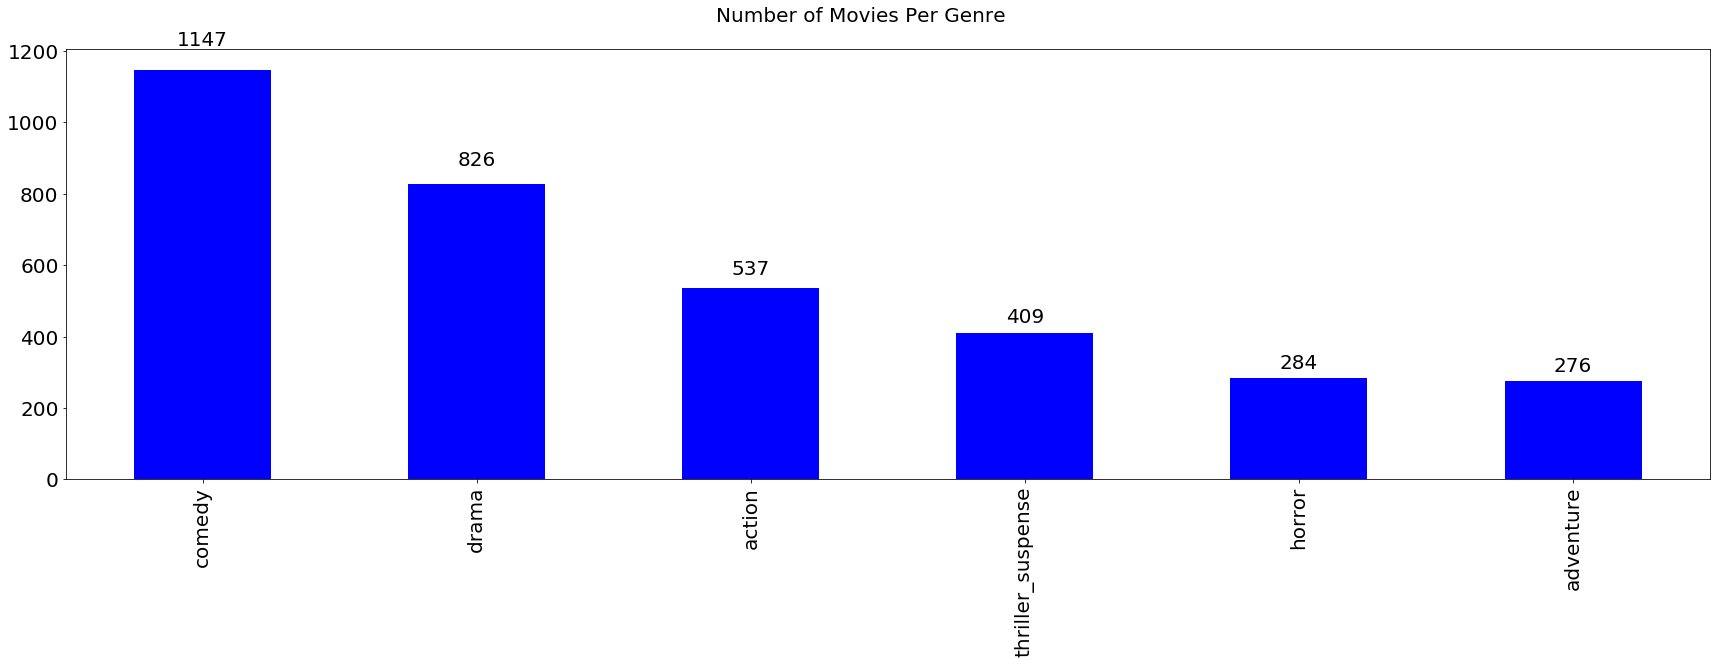

In [18]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
figure.suptitle('Number of Movies Per Genre', fontsize=20, y=1.02)

summary.sort_values('num_movies', ascending=False, inplace=True)

summary.plot(y='num_movies', kind='bar', color=colors[0], ax=axis, legend=False)
axis.set_ylabel('')
axis.set_xlabel('')
axis.tick_params(labelsize=20)
autolabel(axis)

plt.tight_layout()

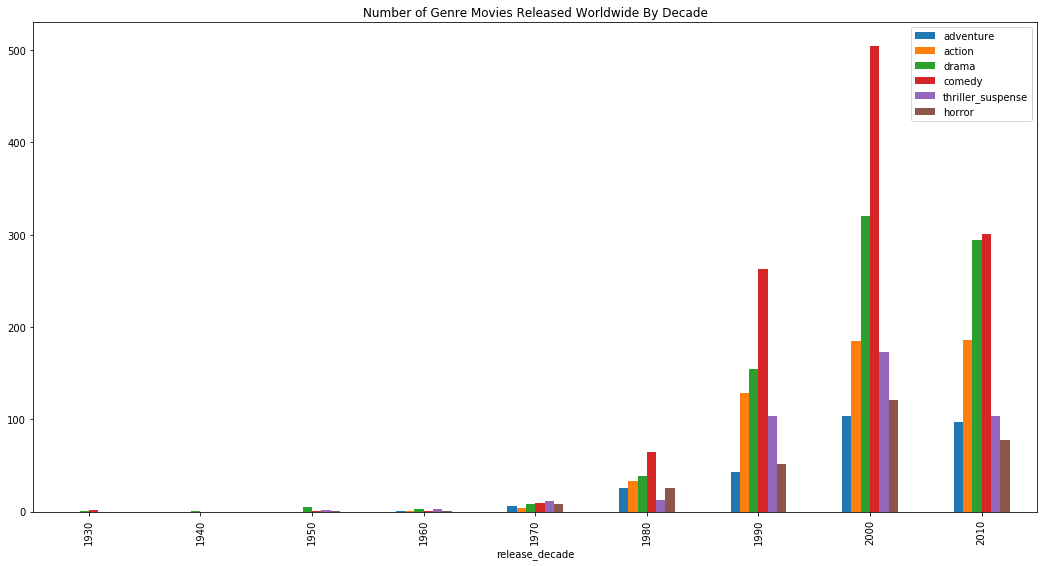

In [54]:
figure, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(18,9))

# Since we are dealing with boolean columns, we must use 'sum' to get the total counts
data.groupby('release_decade').sum().plot.bar(y=['adventure', 'action', 'drama', 'comedy', 'thriller_suspense', 'horror'], ax=ax1, title='Number of Genre Movies Released Worldwide By Decade')

## Worldwide Gross

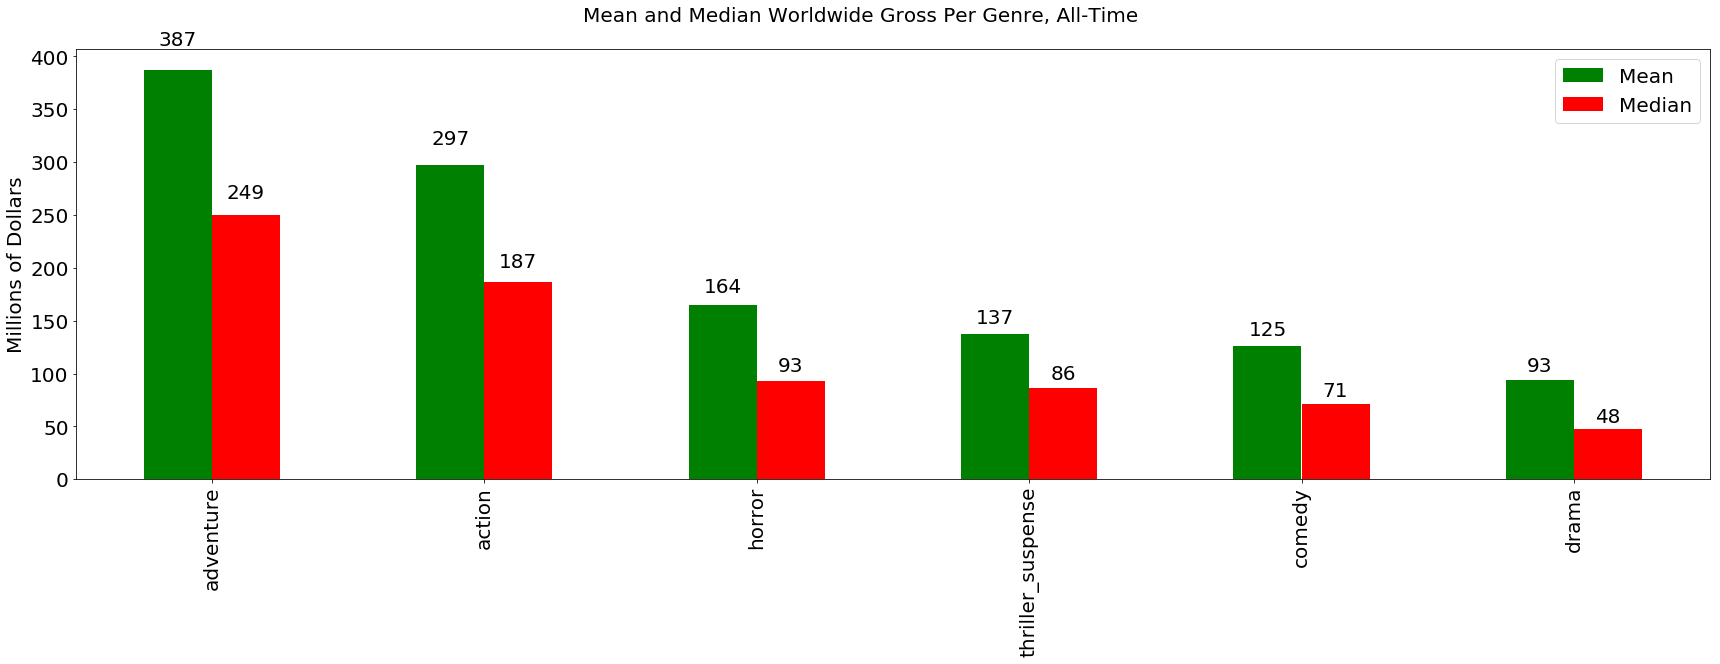

In [53]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
figure.suptitle('Mean and Median Worldwide Gross Per Genre, All-Time', fontsize=20, y=1.02)

summary.sort_values('avg_gross', ascending=False, inplace=True)


axis.plot(summary[['avg_gross', 'median_gross']])



summary.plot(y=['avg_gross', 'median_gross'], kind='bar', ax=axis, color=colors[1:3], legend=True)
axis.set_ylabel('Millions of Dollars', fontsize=20)
axis.set_xlabel('')
axis.tick_params(labelsize=20)
axis.legend(['Mean', 'Median'], fontsize=20)
autolabel(axis)

plt.tight_layout()

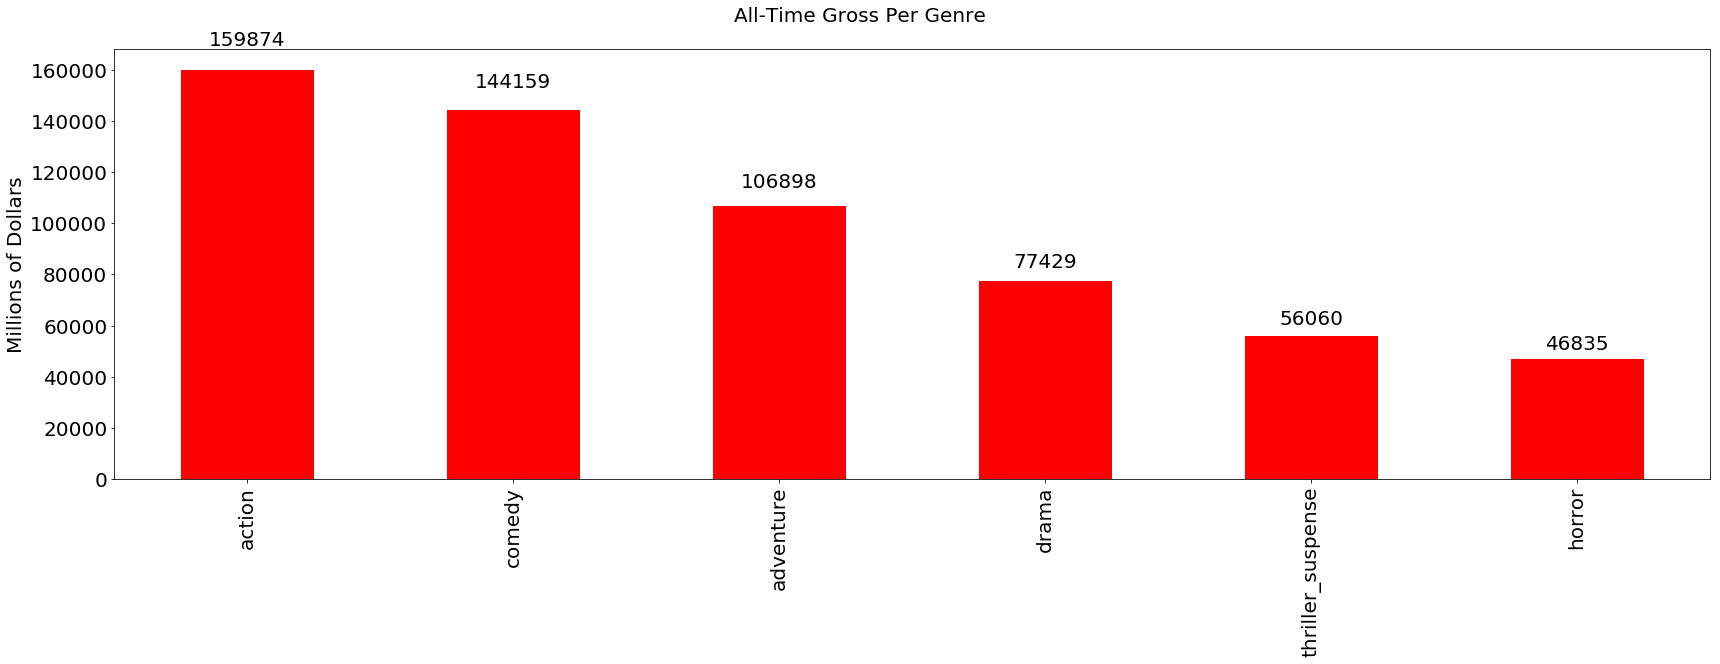

In [50]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
figure.suptitle('All-Time Gross Per Genre', fontsize=20, y=1.02)

summary.sort_values('all_time_gross', ascending=False, inplace=True)

summary.plot(y='all_time_gross', kind='bar', ax=axis, color=colors[2], legend=False)
axis.set_ylabel('Millions of Dollars', fontsize=20)
axis.set_xlabel('')
axis.tick_params(labelsize=20)
autolabel(axis)

plt.tight_layout()

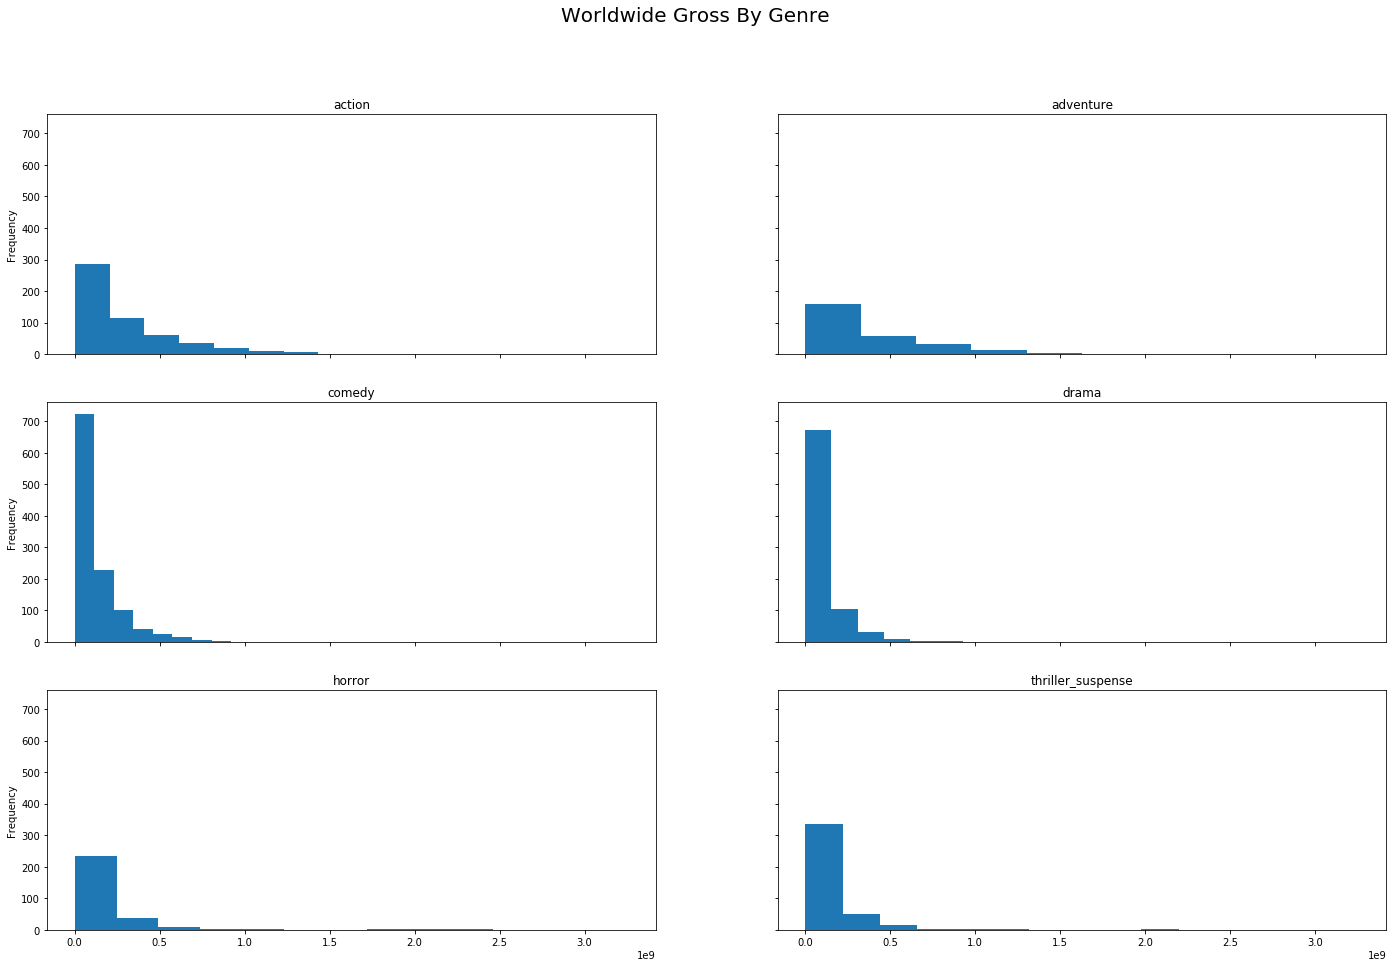

In [78]:
figure, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(24,15))
figure.suptitle('Worldwide Gross By Genre', fontsize=20)
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]

for genre, axis in zip(genres, axes_list):
    data[data[genre]]['worldwide_adj'].plot.hist(ax=axis)
    axis.set_title(genre)

## Production budget

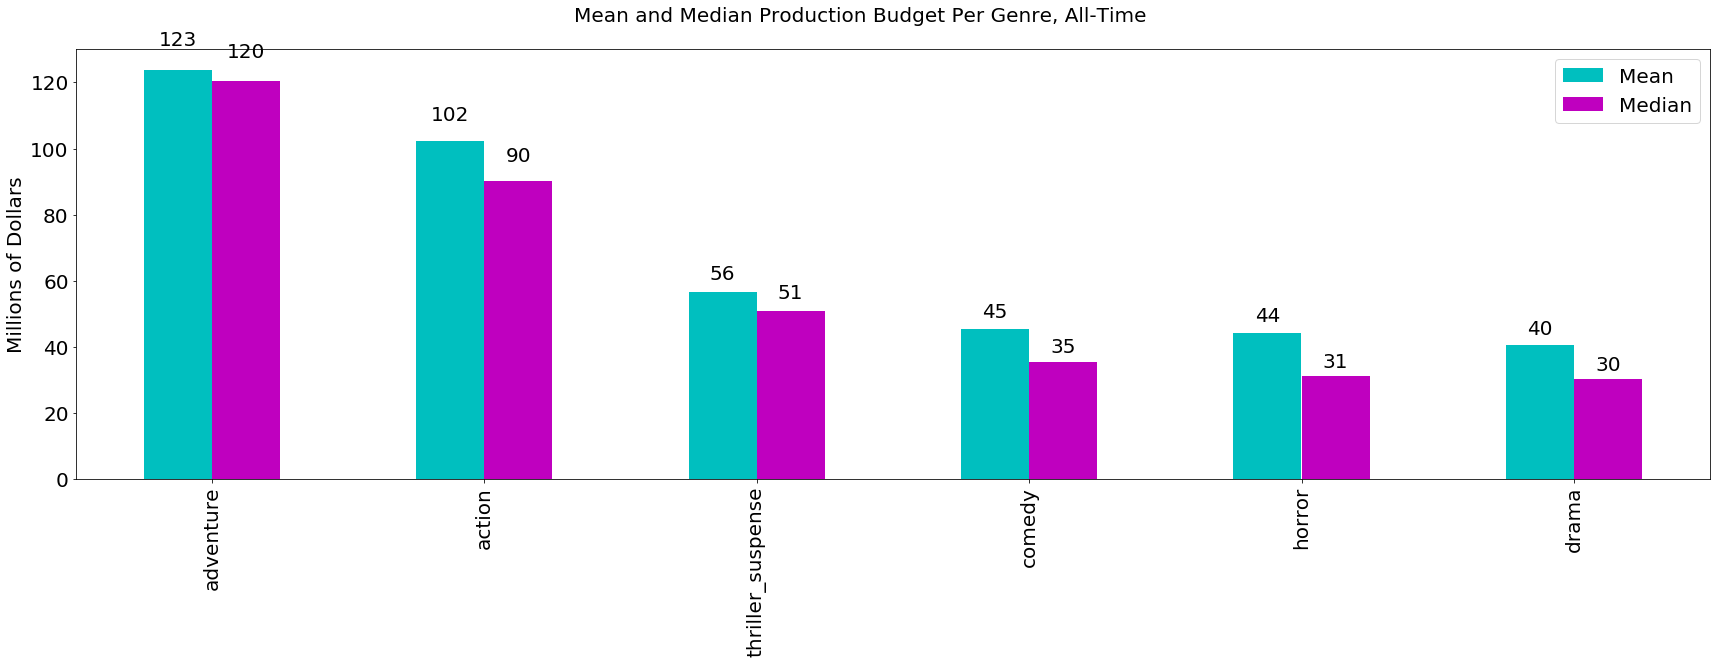

In [46]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
figure.suptitle('Mean and Median Production Budget Per Genre, All-Time', fontsize=20, y=1.02)

summary.sort_values('avg_budget', ascending=False, inplace=True)

summary.plot(y=['avg_budget', 'median_budget'], kind='bar', ax=axis, color=colors[3:5], legend=True)
axis.set_ylabel('Millions of Dollars', fontsize=20)
axis.set_xlabel('')
axis.tick_params(labelsize=20)
axis.legend(['Mean', 'Median'], fontsize=20)
autolabel(axis)

plt.tight_layout()

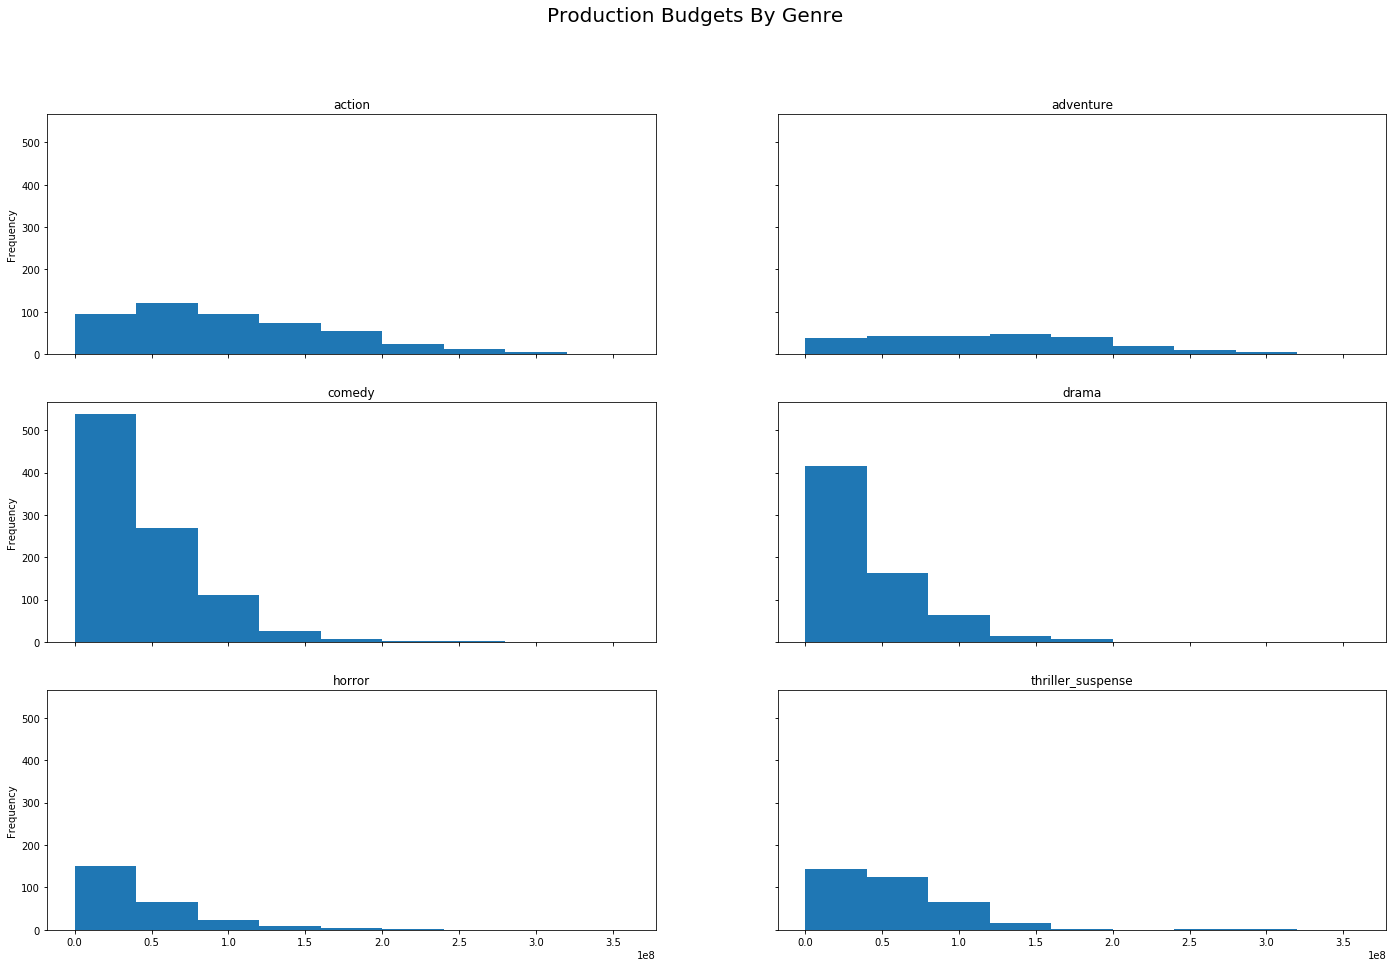

In [77]:
figure, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(24,15))
figure.suptitle('Production Budgets By Genre', fontsize=20)
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]

for genre, axis in zip(genres, axes_list):
    data[data[genre]]['budget_adj'].plot.hist(bins=range(0, 400000000, 40000000), ax=axis)
    axis.set_title(genre)

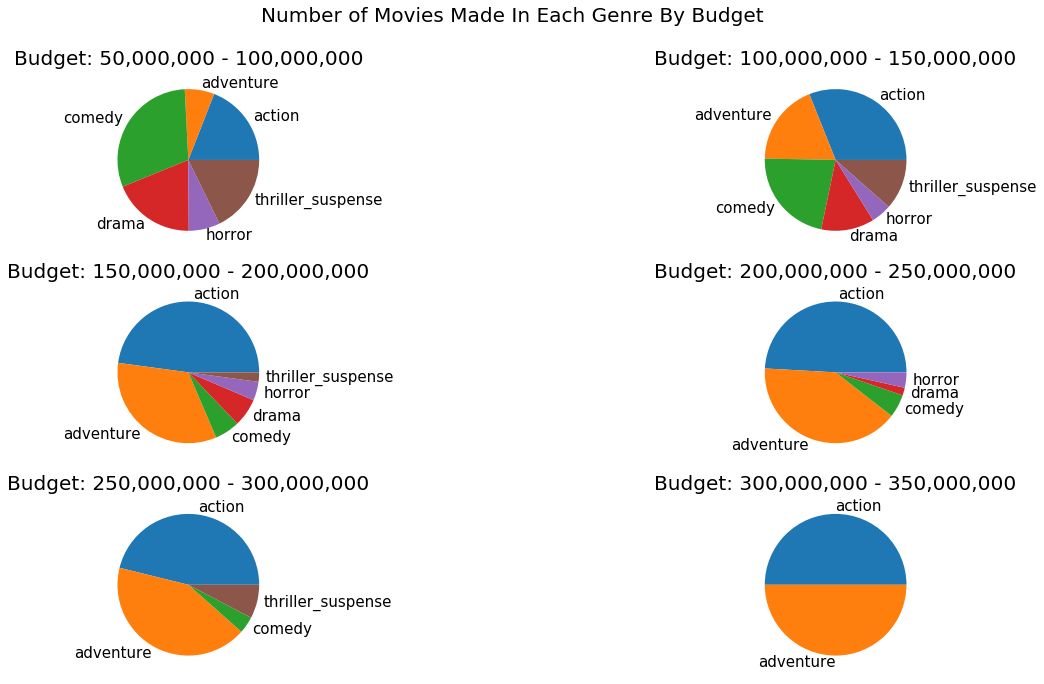

In [161]:
figure, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,9))
figure.suptitle('Number of Movies Made In Each Genre By Budget', fontsize=20, y=1.05)
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]

budgets = range(50000000, 350000000, 50000000)

for budget, axis in zip(budgets, axes_list):
    data[(data['budget_adj'] >= 0 + budget) & (data['budget_adj'] < 50000000 + budget)][genres].sum().plot(kind='pie', ax=axis, fontsize=15)
    axis.set_ylabel('')
    axis.set_title('Budget: {:,} - {:,}'.format(0 + budget, 50000000 + budget), fontsize=20)
    
plt.tight_layout()

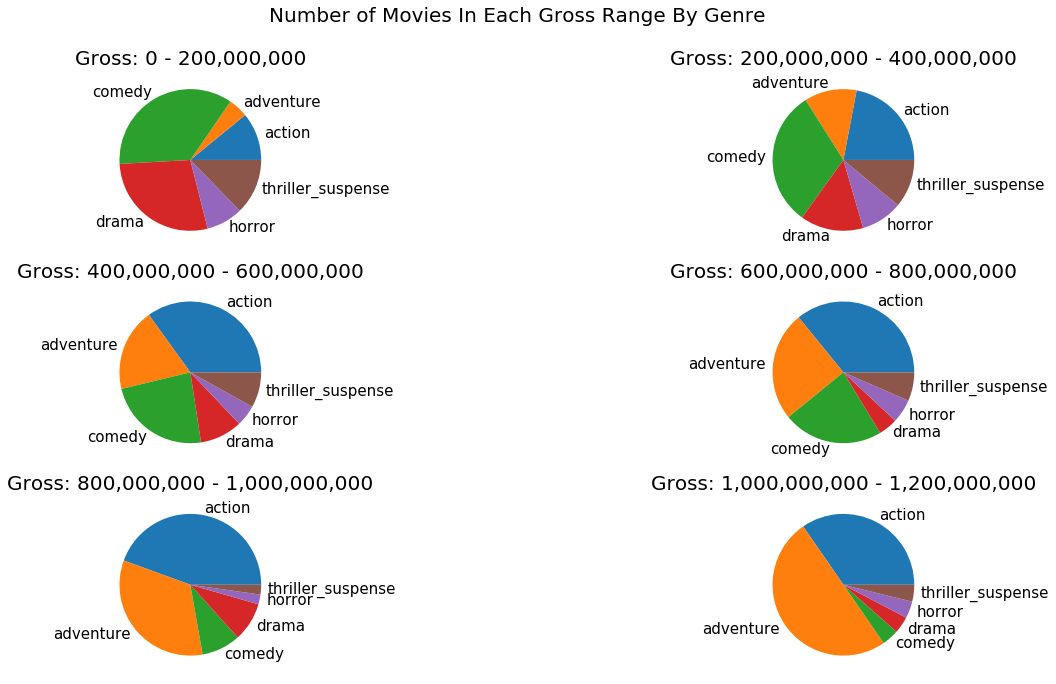

In [164]:
figure, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,9))
figure.suptitle('Number of Movies In Each Gross Range By Genre', fontsize=20, y=1.05)

ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]

grosses = range(0, 1200000000, 200000000)

for gross, axis in zip(grosses, axes_list):
    data[(data['worldwide_adj'] >= 0 + gross) & (data['worldwide_adj'] < gross + 200000000)][worldwide_columns].count().plot(kind='pie', ax=axis, fontsize=15, labels=genres)
    axis.set_ylabel('')
    axis.set_title('Gross: {:,} - {:,}'.format(0 + gross, 200000000 + gross), fontsize=20)
    
plt.tight_layout()

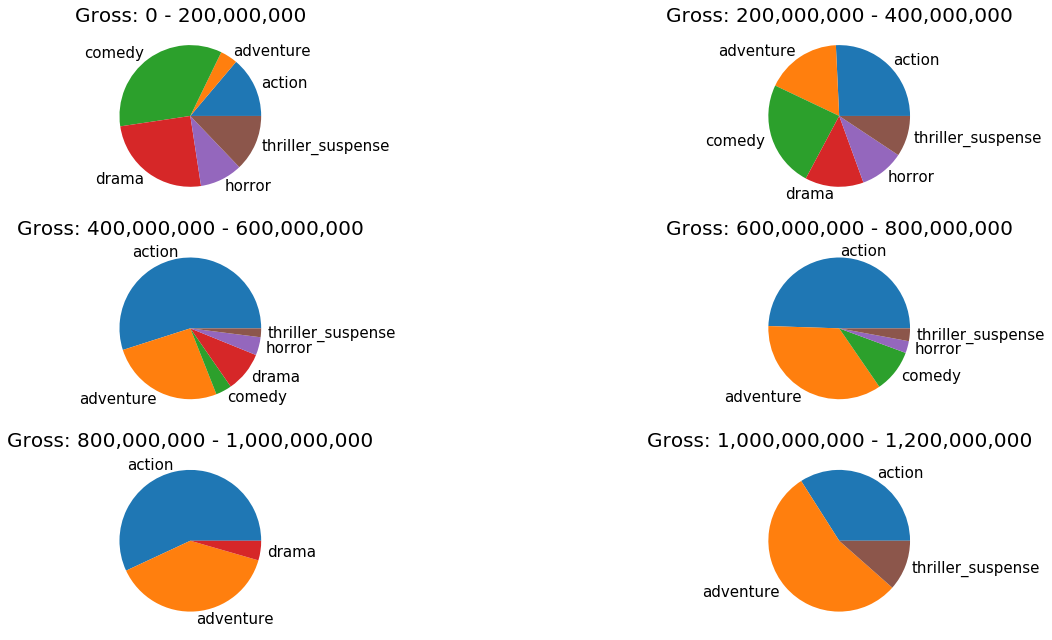

In [153]:
figure, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,9))
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]

grosses = range(0, 1200000000, 200000000)

for gross, axis in zip(grosses, axes_list):
    data[(data['worldwide_adj'] >= 0 + gross) & (data['worldwide_adj'] < gross + 200000000) & (data['release_year'] >= 2010)][worldwide_columns].sum().plot(kind='pie', ax=axis, fontsize=15, labels=genres)
    axis.set_ylabel('')
    axis.set_title('Gross: {:,} - {:,}'.format(0 + gross, 200000000 + gross), fontsize=20)
    
plt.tight_layout()

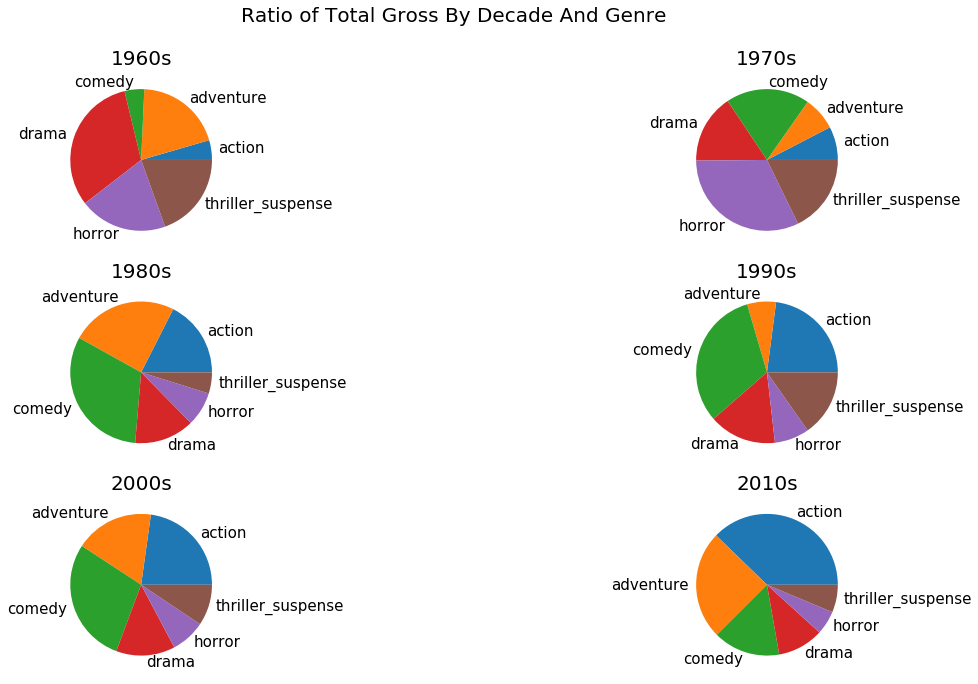

In [165]:
figure, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,9))
figure.suptitle('Ratio of Total Gross By Decade And Genre', fontsize=20, y=1.05)

ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]

decades = range(1960, 2020, 10)

for decade, axis in zip(decades, axes_list):
    data[data['release_decade'] == decade][worldwide_columns].sum().plot(kind='pie', ax=axis, fontsize=15, labels=genres)
    axis.set_ylabel('')
    axis.set_title('{}s'.format(decade), fontsize=20)
    
plt.tight_layout()

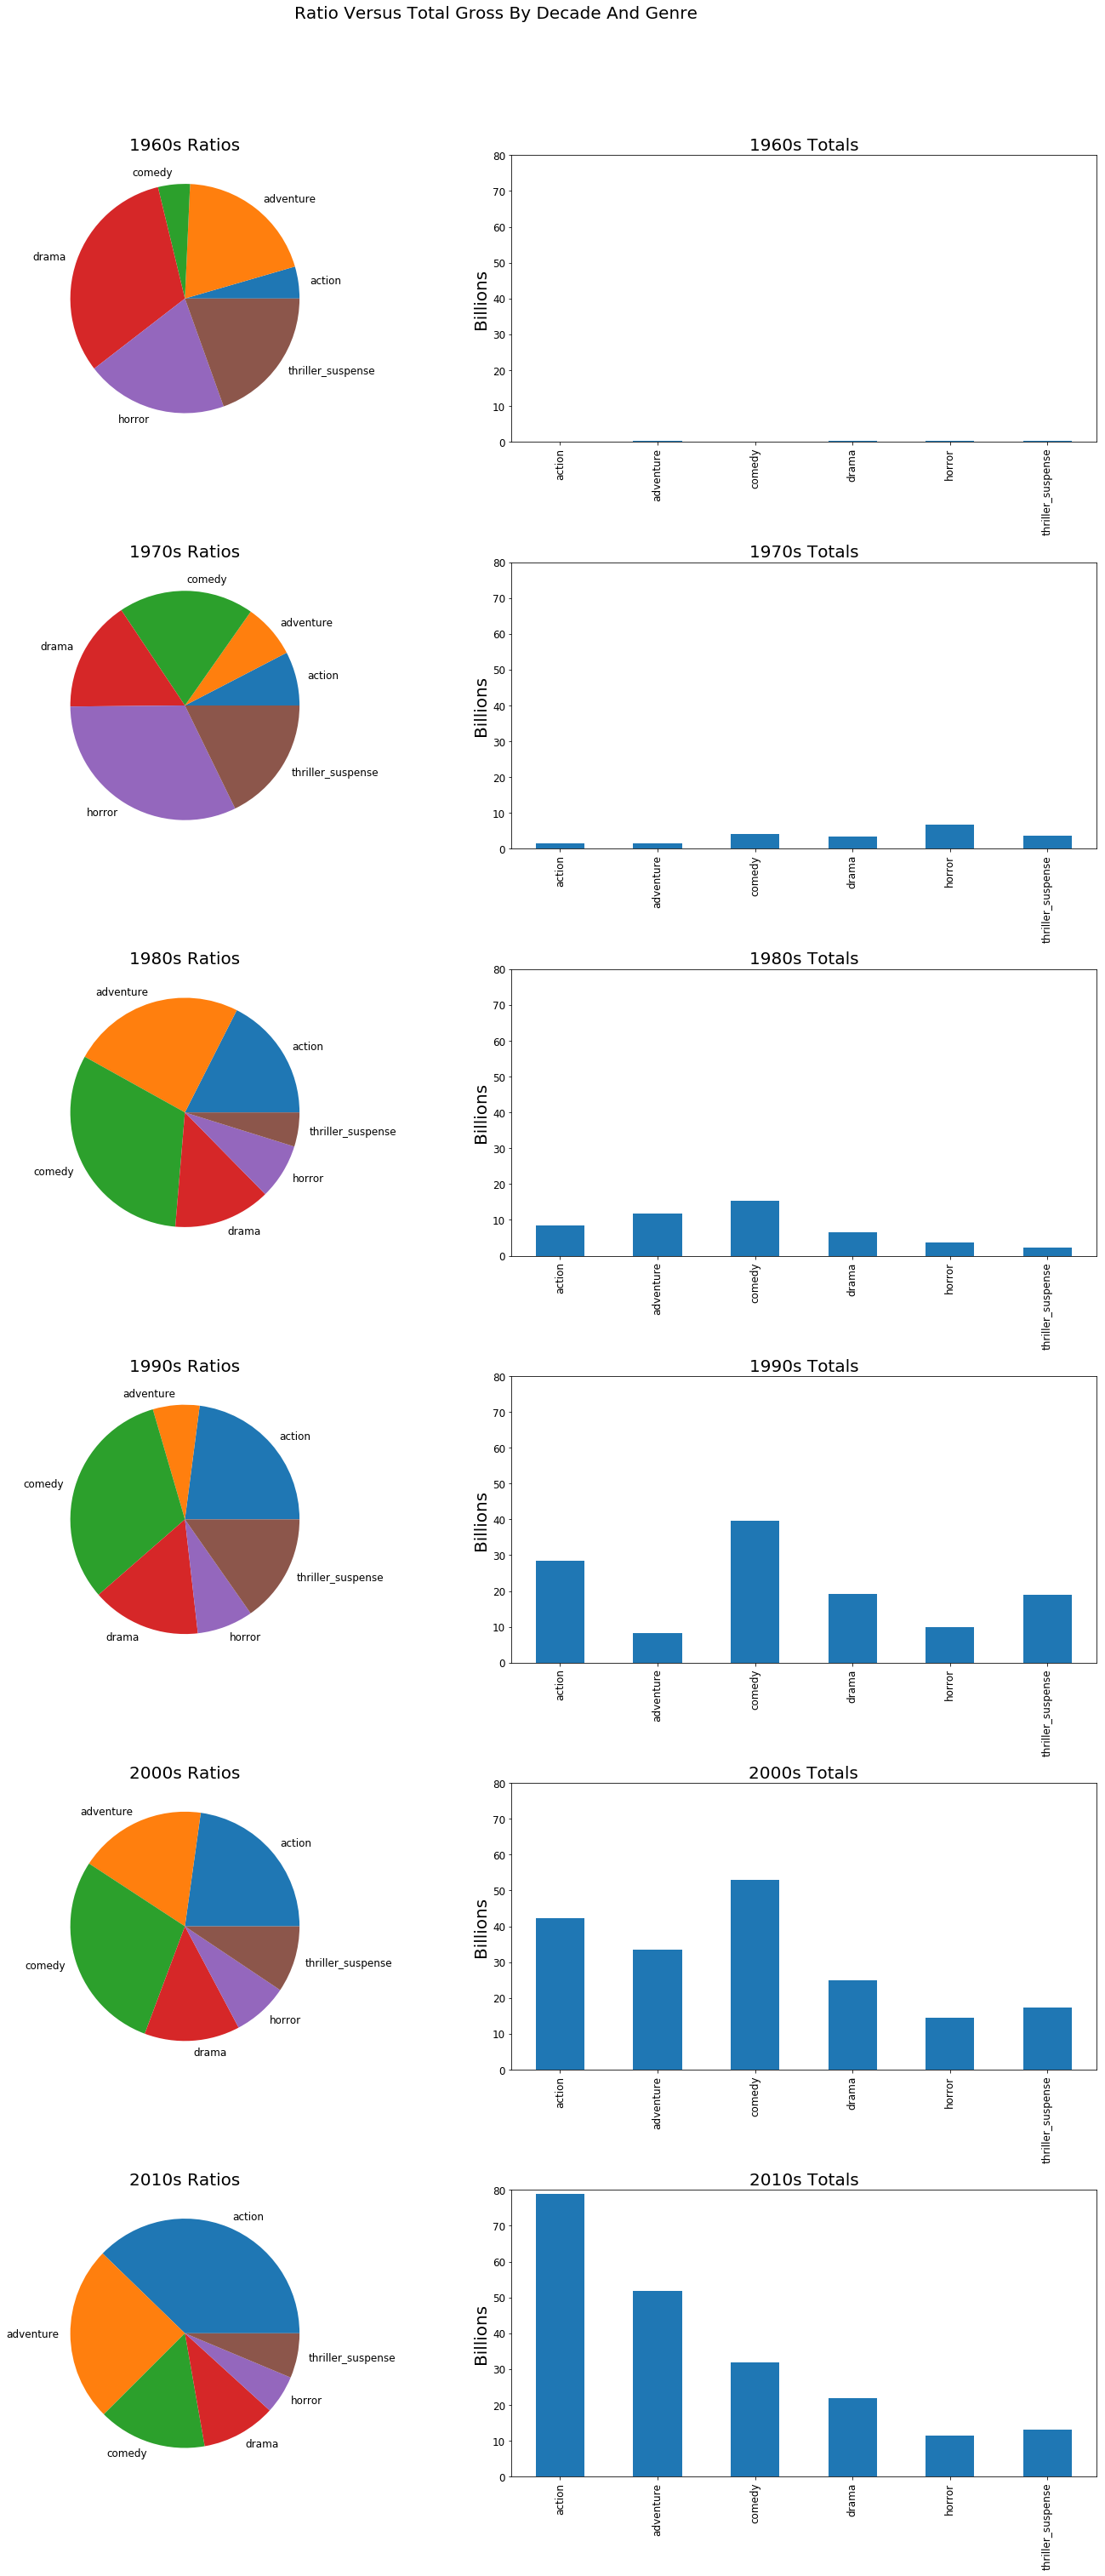

In [200]:
figure, axes = plt.subplots(nrows=6, ncols=2, figsize=(20,40))
figure.suptitle('Ratio Versus Total Gross By Decade And Genre', fontsize=20, y=1.05)

ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12 = axes.flatten()
axes_list1 = [ax1, ax3, ax5, ax7, ax9, ax11]
axes_list2 = [ax2, ax4, ax6, ax8, ax10, ax12]

decades = range(1960, 2020, 10)

for decade, axis1, axis2 in zip(decades, axes_list1, axes_list2):
    (data[data['release_decade'] == decade][worldwide_columns].sum() / 1000000000).plot(kind='pie', ax=axis1, fontsize=12, labels=genres)
    (data[data['release_decade'] == decade][worldwide_columns].sum() / 1000000000).plot(kind='bar', ax=axis2, fontsize=12, ylim=(0,80))
    axis1.set_ylabel('')
    axis1.set_title('{}s Ratios'.format(decade), fontsize=20)
    axis2.set_xticklabels(genres)
    axis2.set_title('{}s Totals'.format(decade), fontsize=20)
    axis2.set_ylabel('Billions', fontsize=20)
plt.tight_layout()

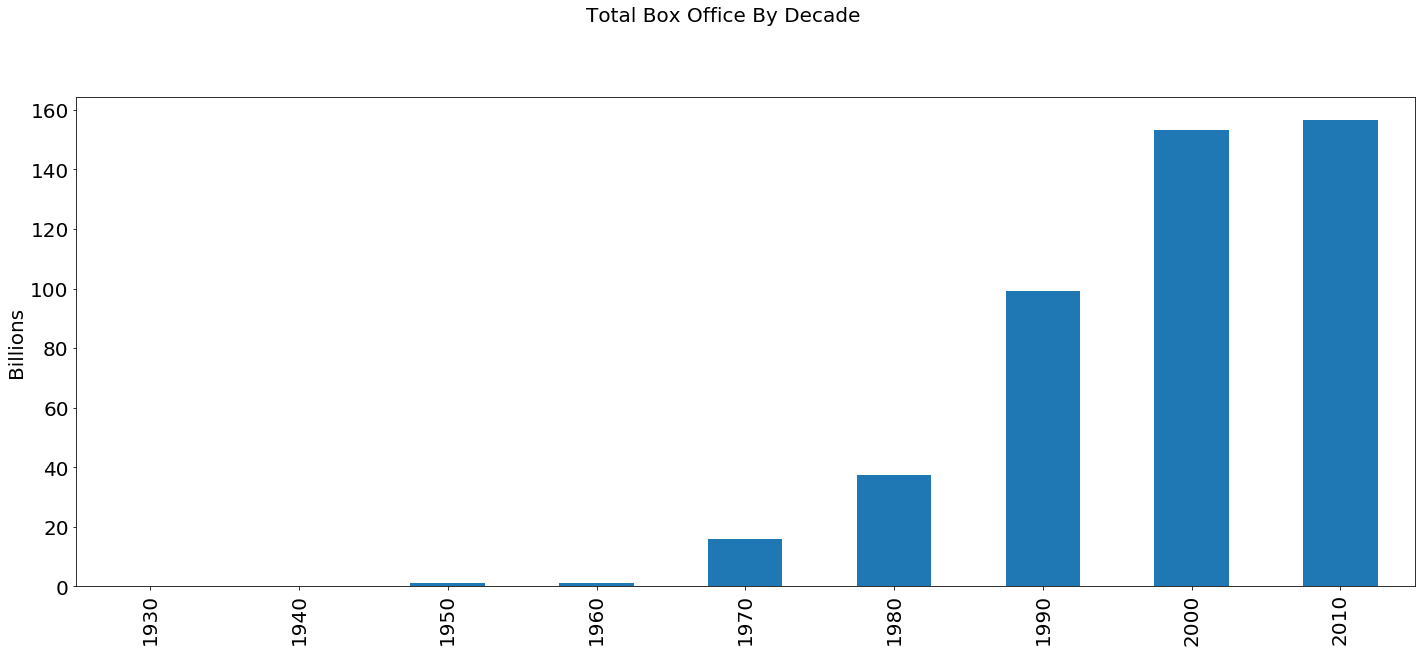

In [204]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24,9))
figure.suptitle('Total Box Office By Decade', fontsize=20, y=1.02)

(data.groupby('release_decade')['worldwide_adj'].sum() / 1000000000).plot(kind='bar', fontsize=20)
axis.set_ylabel('Billions', fontsize=20)
axis.set_xlabel('');

In [107]:
grp = data[data['budget_adj'] >= 100000000][genres]
grp.sum()

action               210
adventure            146
comedy                83
drama                 49
horror                23
thriller_suspense     42
dtype: int64

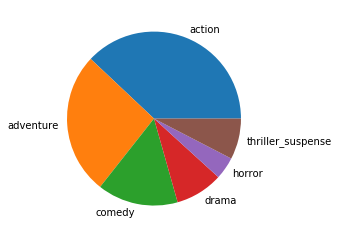

In [110]:
ax = grp.sum().plot(kind='pie')
ax.set_ylabel('');

In [82]:
data[['title', 'genres_mojo', 'worldwide_adj']].sort_values(by='worldwide_adj', ascending=False)

,title,genres_mojo,worldwide_adj
1543,Avatar,Sci-Fi Adventure,3.256402e+09
15395,The Exorcist,Horror,2.458814e+09
7815,Jaws,Horror Thriller,2.196843e+09
4660,E.T.:The Extra-Terrestrial,Family Adventure,2.063268e+09
1548,Avengers:Infinity War,Action / Adventure,2.048360e+09
8021,Jurassic Park,Sci-Fi Horror,1.797145e+09
8025,Jurassic World,Action / Adventure,1.758983e+09
9540,Marvel's The Avengers,Action / Adventure,1.661126e+09
5784,Furious 7,Action,1.607589e+09
15649,The Godfather,Crime Drama,1.542585e+09


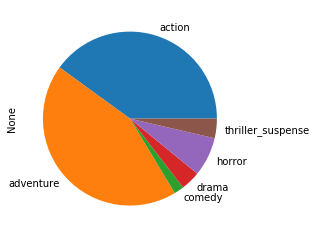

In [97]:
grp = data[data['worldwide_adj'] >= 1000000000][genres]
grp.sum().plot(kind='pie')

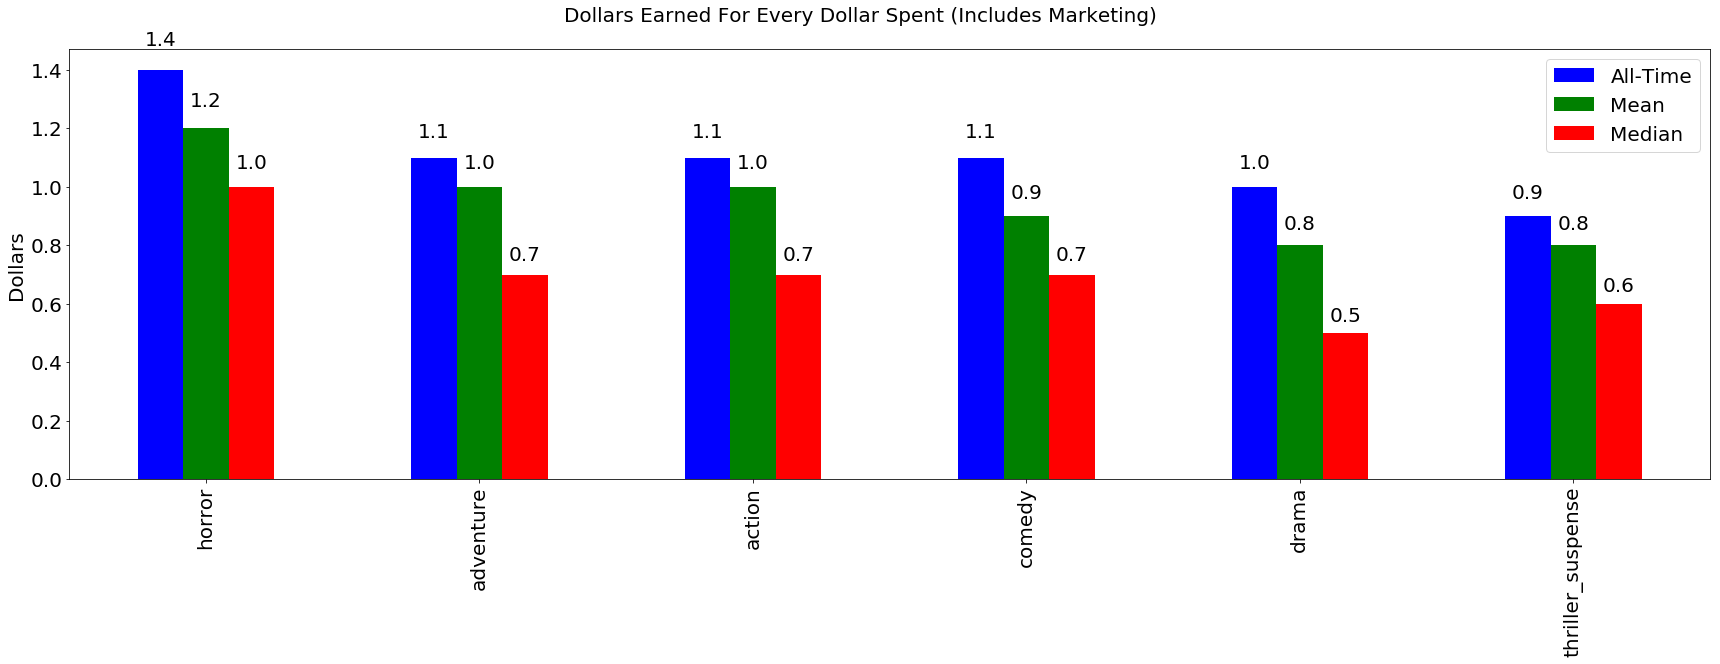

In [75]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
figure.suptitle('Dollars Earned For Every Dollar Spent (Includes Marketing)', fontsize=20, y=1.02)

summary.sort_values('dollars_earned_for_dollars_spent', ascending=False, inplace=True)

summary.plot(y=['dollars_earned_for_dollars_spent', 'mean_dollars_earned_for_dollars_spent', 'median_dollars_earned_for_dollars_spent'], kind='bar', ax=axis, color=colors[0:3], legend=True)
axis.set_ylabel('Dollars', fontsize=20)
axis.set_xlabel('')
axis.tick_params(labelsize=20)
axis.legend(['All-Time', 'Mean', 'Median'], fontsize=20)
autolabel(axis, num_decimals=1)

plt.tight_layout()

# Initial Thoughts

**Number of movies**
  - `Comedy` and `Drama` are historically the most produced genres by big movie studios by a healthy margin
  - They have been the top two spots for the last four decades
  
  
**Average worldwide gross**
  - `Adventure` and `Action` historically gross the highest average amount per movie
  - `Adventure` has an average worldwide gross that is more than double the genre in third place
  - Perhaps surprisingly, `Horror` is in third place
  - The means are skewed by really high-grossing movies in each genre, as the means are much higher than medians 


**All-Time Gross Per Genre**
  - In aggregate, `Action`, `Comedy`, then `Adventure` have grossed the most money worldwide
  - `Action` is ahead of `Comedy` by almost \\$16 billion dollars
  
  
**Average production budget**
  - `Adventure` and `Action` have by far the largest average production budget. This makes sense, as those movies tend to require more setpieces and CGI than other genres
  - Both `Adventure` and `Action` are at least double the average production budget of the third place genre, `Thriller/Suspense`
  - `Comedy`, `Horror`, and `Drama` all have very similar, low average production budgets 
  - There aren't huge outliers with production budgets as the medians and means are very consistent for all genres. This cap indicates there are spending thresholds that studios don't pass on production budgets. 
  
  
**Dollar earned for every dollar spent**
  - `Horror` earns a studio approximately 1.4 dollars for every dollar spent
  - `Adventure`, `Action`, and `Comedy` are all tied for second place with 1.1 dollars earned per dollar spent
  - Except `Thriller/Suspense`, every genre in aggregate is at least breakeven on a dollar for dollar basis 
  

**Summing up**

`Action`, `Comedy`, and `Adventure` have made the most overall money worldwide. `Action` and `Adventure` have far higher average worldwide grosses than `Comedy`. `Comedy` must be making up for this with its higher numbers of movies released. However, `Adventure` and `Action` are the two most expensive genres to make, whereas `Comedy` is fourth.

The best return for every dollar spent in aggregate come from `Horror` and `Adventure`.

When taking into account our domestic box office analysis, now we see the reason `Action` and `Adventure` movies are made. They were net losers domestically, but make up for this with much higher worldwide grosses. 
- `Action`:
  - Average domestic gross: \\$116 million
  - Average worldwide gross: \\$297 million

- `Adventure`:
  - Average domestic gross: \\$151 million
  - Average worldwide gross: \\$387 million

That's a difference of \\$181 million and \\$236 million respectively!  

There are a couple strategies our bosses can consider:

1) Go for the safest genre. Our bosses are less likely to lose big money on `Horror`. It's one the cheapest genres to produce and has the highest average dollar earned per dollar spent.

2) Swing for the fences. If they can afford to be risky, `Adventure` and `Action` historically have the highest earnings potential. This is probably due to their ability to travel well and be unimpeded by language barriers. Anyone in the world can watch a fight scene, car chase, or explosion and understand what's happening. 

Let's look at each genre's performance by decade to see if there are recent trends we can spot.

# Performance By Decade

## All Decades

### Worldwide Gross

In [ ]:
# Create variables for first_axes, secondary_axes, and counter variables 
ax1, ax2, ax3, ax4, ax5, ax6 = 'abcdef'
first_axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]

ax1_1, ax2_1, ax3_1, ax4_1, ax5_1, ax6_1 = 'abcdef'
second_axes_list = [ax1_1, ax2_1, ax3_1, ax4_1, ax5_1, ax6_1]

# Counters to keep track of iteration
counters = [0, 1, 2, 3, 4, 5]

for genre, first_axis, second_axis, color, count in zip(genres, first_axes_list, second_axes_list, colors, counters):
        figure, first_axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 10))
        second_axis = figure.add_axes()

        # Only write the title once
        if count == 0:
            figure.suptitle('Mean Worldwide Gross By Genre And Decade\n(Counts Labeled)', fontsize=20, y=1.02)

        grp = (data[data[genre]].groupby('release_decade').mean() / 1000000)['worldwide_adj'].copy()
        grp_counts = data[data[genre]].groupby('release_decade')['worldwide_adj'].count().copy()
    
        # If the series is missing a decade, add it as an index and set the value to zero
        for decade in range(1910, 2020, 10):
            if decade not in grp.index:
                grp.loc[decade] = 0
                grp_counts.loc[decade] = 0

        # Sort the series by its index to have the decades in chronological order                
        grp.sort_index(ascending=True, inplace=True)
        grp_counts.sort_index(ascending=True, inplace=True)
        
        # Set up y-axis    
        first_axis = grp.plot(kind='bar', xticks=range(1910, 2020, 10), linewidth=3, color=color)
        first_axis.set_ylabel('Worldwide Gross In Millions', fontsize=12)
        first_axis.set_ylim(0,900)
        first_axis.legend([genre], loc=2, fontsize=15)
        
        autolabel(first_axis, counts=grp_counts.values)
        
        # Set up second y-axis
        second_axis = first_axis.twinx()
        second_axis.plot(first_axis.get_xticks(), grp_counts.values, linewidth=3, color='k')
        second_axis.set_ylabel('Number of Movies', fontsize=12)
        second_axis.set_ylim(0,600)
        second_axis.legend(['counts'], loc=1, fontsize=15)
        
        # Only show graphs when on the last one
        if count == len(counters) - 1:
            plt.tight_layout()

Key Takeaways:

**1970s were the best!**
- Either our dataset only has big winners from the 1970s, or we should have stopped making movies after then! We have far fewer movies from the 1970s in our dataset, but the average worldwide grosses there are way higher than any other decade. We should be cautious in drawing conclusions there without investigating this closer.

**Changes since the 1990s**
- `Action` and `Adventure` have by far the biggest increases in average worldwide gross. The other genres all earn less on average than they did in the 1990s.
- Every genre had a big jump in the number of movies released from the 1990s to the 2000s. 
- Only `Action` has had more movies released from the 2000s to the 2010s. Every other genre has had a steep decline in output.

**Horror and Thriller/Suspense comeback**
- Though much smaller than the increase in `Action` and `Adventure` grosses, `Horror` and `Thriller/Suspense` have had their average gross increase from the 2000s to the 2010s.

**Fewer movies made now**
- Our gut should tell us movies are not as profitable now as they used to be because the Big Five release far fewer movies now than they did in the 2000s.

### Production Budget

In [ ]:
figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(24, 16))
figure.suptitle('Mean Production Budget By Genre And Release Decade', fontsize=20, y=1.02)

ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]

for genre, axis, color in zip(genres, axes_list, colors):
    # We must replace missing decades with zeroes to have the bar plots xticks line up
    
    # Create a series with decades as indexes and domestic gross as values
    grp = (data[data[genre]].groupby('release_decade').mean() / 1000000)['budget_adj'].copy()
    
    # If the series is missing a decade, add it as an index and set the value to zero
    for decade in range(1910, 2020, 10):
        if decade not in grp.index:
            grp.loc[decade] = 0
    
    # Sort the series by its index to have the decades in chronological order                
    grp.sort_index(ascending=True, inplace=True)
        
    grp.plot(kind='bar', xticks=range(1910, 2020, 10), ax=axis, linewidth=3, color=color)
    axis.set_ylabel('Production Budget In Millions', fontsize=12)
    axis.legend([genre], loc=2, fontsize=15)
    autolabel(axis)

plt.tight_layout() 

Key Takeaways:
- Production budgets for Action and Adventure have been increasing since the 1980s
- Production budgets for all other genres have declined since the 1990s
- This is probably due to the heavy use of expensive CGI in Action and Adventure movies, which has only increased over time. Meanwhile, technological advancements have decreased the overall cost of producing movies in general.

### Worldwide Breakeven Percentage

In [ ]:
# Create new column on summary dataframe to hold the most recent breakeven percentage by genre
summary['2010s_breakeven_percent'] = np.nan

In [ ]:
figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(24, 16))
figure.suptitle('Worldwide Breakeven Percentage By Decade\n(Counts Labeled)', fontsize=20, y=1.05)

ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]

for genre, axis, color in zip(genres, axes_list, colors):
    # Create two series with decades as indexes and count and sum as values
    grp_count = data[data[genre]].groupby('release_decade')['worldwide_breakeven'].count().copy()
    grp_sum = data[data[genre]].groupby('release_decade')['worldwide_breakeven'].sum().copy()

    # If the series is missing a decade, add it as an index
    # Then set the count to 1 and the sum to 0
    # This avoids division by zero problems when calculating the percentages
    for decade in range(1910, 2020, 10):
        if decade not in grp_count.index:
            grp_count.loc[decade] = 0
            grp_sum.loc[decade] = 0

    # Sort the series by their index to have the decades in chronological order                
    grp_count.sort_index(ascending=True, inplace=True)
    grp_sum.sort_index(ascending=True, inplace=True)
    
    summary.loc[genre, ['2010s_breakeven_percent']] = round((grp_sum / grp_count * 100).loc[2010],1)

    (grp_sum / grp_count * 100).plot(kind='bar', xticks=range(2010, 2019, 1), ax=axis, linewidth=3, color=color)
    axis.set_ylabel('Percentage', fontsize=12)
    axis.legend([genre], loc=2, fontsize=15)
    
    # Put the count of how many movies breakeven above each bar
    autolabel(axis, counts=grp_count.values)
    
plt.tight_layout() 

In [ ]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
figure.suptitle('2010s Breakeven Percentage By Genre', fontsize=20, y=1.02)

summary.sort_values('2010s_breakeven_percent', ascending=False, inplace=True)

summary.plot(y='2010s_breakeven_percent', kind='bar', ax=axis, color=colors[0], legend=False)
axis.set_ylabel('Percentage', fontsize=20)
axis.set_xlabel('')
axis.tick_params(labelsize=20)
autolabel(axis, num_decimals=1)

plt.tight_layout()

### Quick Thoughts

**Movies are more risky now**
  - From the 1960s to 1990s, for most genres, there was an overall decrease in a movie's probability of breaking even
  - Such a decrease went alongside a huge increase in the numbers of movies released overall
  - The market might have gotten oversaturated, at which point the same amount of consumer dollars could not support the increase in movies
  
  - From the 1990s to the 2010s, every genre has seen an increase in a movie's probability of breaking even
  - This reduction in output coincides with an increase in a genre's probability of success
  - It could be that a huge contributor to a movie's ultimate success is just the number of movies it has to compete with

**Safest current genres**
  - `Horror` is by far the safest domestic release genre
  - `Thriller/Suspense`, and `Comedy` are the next safest from a breakeven perspective
  - `Action` and `Adventure` have very little chance of breaking even in just the domestic market

In [ ]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
figure.suptitle('Number of Movies Released By Decade and Genre', fontsize=20, y=1.02)

grp = data.groupby('release_decade')['action', 'adventure', 'comedy', 'drama', 'horror', 'thriller_suspense'].sum()

grp.plot(kind='bar', stacked=True, ax=axis)
axis.set_ylabel('Number of Movies', fontsize=20)
axis.set_xlabel('')
axis.tick_params(labelsize=20)
axis.legend(fontsize=20)

plt.tight_layout()

# Stacked Chart Worldwide Gross By Decade

In [88]:
# We want individual columns that hold the worldwide gross for each genre
# Since a movie can have multiple genres, right now we must handle this by a groupby while looping over each genre
# If we create individual columns that contain information about a genre and its worldwide box office, it's easier to graph
def worldwide_gross_by_genre(row, genre):
    # Returns either 0 or the `worldwide_adj` value due to boolean multiplication
    test = row[genre] * row['worldwide_adj']
    
    # If the row is not in the genre (i.e. False * $100 = 0)
    if test == 0:
        return np.nan
    else:
        return test

# List of new columns to hold worldwide grosses by genre
worldwide_columns = ['worldwide_gross_{}'.format(genre) for genre in genres]

for genre, col in zip(genres, worldwide_columns):
    data[col] = data.apply(lambda x: worldwide_gross_by_genre(x, genre), axis=1)

In [ ]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
figure.suptitle('Total Worldwide Gross By Genre and Decade', fontsize=20, y=1.02)

grp = data.groupby('release_decade')[worldwide_columns].sum() / 1000000000
grp.plot(kind='bar', stacked=True, ax=axis)
axis.set_ylabel('Billions of Dollars', fontsize=20)
axis.set_xlabel('')
axis.tick_params(labelsize=20)
axis.legend(genres, fontsize=20)

plt.tight_layout()

We have a lot of duplicated movie entries when looking at total numbers. The reason is many movies are categorized as `Action / Adventure`. These movies tend to make a lot of money. This artificially boosts the totals for both `Action` and `Adventure`.

In [ ]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
figure.suptitle('Mean Worldwide Gross By Genre and Decade', fontsize=20, y=1.02)

grp = data.groupby('release_decade')[worldwide_columns].mean() / 1000000
grp.plot(kind='bar', stacked=True, ax=axis)
axis.set_ylabel('Millions of Dollars', fontsize=20)
axis.set_xlabel('')
axis.tick_params(labelsize=20)
axis.legend(genres, fontsize=20)

plt.tight_layout()

# Extras

In [ ]:
# Create worldwide gross by genre columns
def breakeven_by_genre(row, genre):
    if row[genre] is False:
        return np.nan
    
    if row['worldwide_breakeven'] is False:
        return 0
    else:
        return 1
    
# List of new columns to hold worldwide grosses by genre
breakeven_columns = ['breakeven_{}'.format(genre) for genre in genres]

for genre, col in zip(genres, breakeven_columns):
    data[col] = data.apply(lambda x: breakeven_by_genre(x, genre), axis=1)

### Only Looking At Movies With A Production Budget

In [ ]:
has_budget = data[data['budget_adj'].notna()].copy()
has_budget.info()

In [ ]:
figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(24, 16))
figure.suptitle('Dollars Earned For Every Dollar Spent By Decade (Includes Marketing)\n(Percentages Labeled)', fontsize=20, y=1.05)

ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]

for genre, axis, color in zip(genres, axes_list, colors):
    # Create two series with decades as indexes and count and sum as values
    grp_gross_count = has_budget[has_budget[genre]].groupby('release_decade')['domestic_adj'].count().copy()
    grp_gross_sum = has_budget[has_budget[genre]].groupby('release_decade')['domestic_adj'].sum().copy()
    
    grp_budget_count = has_budget[has_budget[genre]].groupby('release_decade')['budget_adj'].count().copy()
    grp_budget_sum = has_budget[has_budget[genre]].groupby('release_decade')['budget_adj'].sum().copy()

    # If the series is missing a decade, add it as an index
    # Then set the count to 1 and the sum to 0
    # This avoids division by zero problems when calculating the percentages
    for decade in range(1910, 2020, 10):
        if decade not in grp_gross_count.index:
            grp_gross_count.loc[decade] = 0
            grp_gross_sum.loc[decade] = 0
        
        if decade not in grp_budget_count.index:
            grp_budget_count.loc[decade] = 0
            grp_budget_sum.loc[decade] = 1

    # Sort the series by their index to have the decades in chronological order                
    grp_gross_count.sort_index(ascending=True, inplace=True)
    grp_gross_sum.sort_index(ascending=True, inplace=True)
    grp_budget_count.sort_index(ascending=True, inplace=True)
    grp_budget_sum.sort_index(ascending=True, inplace=True)
    
    dollars_earned_to_dollars_spent = round((grp_gross_sum / (1.5 * grp_budget_sum)), 1)
            
    dollars_earned_to_dollars_spent.plot(kind='bar', xticks=range(1910, 2020, 10), ax=axis, linewidth=3, color=color)
    axis.set_ylabel('Dollars', fontsize=12)
    axis.legend([genre], loc=2, fontsize=15)
    
    # Put the percentage of how many movies breakeven above each bar
    autolabel(axis, num_decimals=1)
    
plt.tight_layout() 

In [ ]:
figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(24, 16))
figure.suptitle('Dollars Earned For Every Dollar Spent By Decade (Includes Marketing)\n(Counts Labeled)', fontsize=20, y=1.05)

ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]

for genre, axis, color in zip(genres, axes_list, colors):
    # Create two series with decades as indexes and count and sum as values
    grp_gross_count = has_budget[has_budget[genre]].groupby('release_decade')['domestic_adj'].count().copy()
    grp_gross_sum = has_budget[has_budget[genre]].groupby('release_decade')['domestic_adj'].sum().copy()
    
    grp_budget_count = has_budget[has_budget[genre]].groupby('release_decade')['budget_adj'].count().copy()
    grp_budget_sum = has_budget[has_budget[genre]].groupby('release_decade')['budget_adj'].sum().copy()

    # If the series is missing a decade, add it as an index
    # Then set the count to 1 and the sum to 0
    # This avoids division by zero problems when calculating the percentages
    for decade in range(1910, 2020, 10):
        if decade not in grp_gross_count.index:
            grp_gross_count.loc[decade] = 0
            grp_gross_sum.loc[decade] = 0
        
        if decade not in grp_budget_count.index:
            grp_budget_count.loc[decade] = 0
            grp_budget_sum.loc[decade] = 1

    # Sort the series by their index to have the decades in chronological order                
    grp_gross_count.sort_index(ascending=True, inplace=True)
    grp_gross_sum.sort_index(ascending=True, inplace=True)
    grp_budget_count.sort_index(ascending=True, inplace=True)
    grp_budget_sum.sort_index(ascending=True, inplace=True)
    
    dollars_earned_to_dollars_spent = round((grp_gross_sum / (1.5 * grp_budget_sum)), 1)
            
    dollars_earned_to_dollars_spent.plot(kind='bar', xticks=range(1910, 2020, 10), ax=axis, linewidth=3, color=color)
    axis.set_ylabel('Dollars', fontsize=12)
    axis.legend([genre], loc=2, fontsize=15)
    
    # Put the count of how many movies breakeven above each bar
    autolabel(axis, counts=grp_gross_count.values)
    
plt.tight_layout() 

### Quick Takeaways

**Recent data is more reliable**
  - We don't have many movies before the 1970s, so drawing conclusions there seems risky. For example, the huge spike in `Horror` in 1950 is due to a single movie.
  - We should be able to trust the more recent data as there are far more movies available.
  
**Last three decades**
  - `Horror`, `Comedy`, and `Drama` are the best dollar for dollar movies.

## Current Decade

In [ ]:
current = data[data['release_year'] >= 2010].copy()

figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(24, 16))
figure.suptitle('Percentage of Movies That Breakeven This Decade\n (Counts are labeled)', fontsize=20, y=1.05)

ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]

for genre, axis, color in zip(genres, axes_list, colors):
    # Create two series with decades as indexes and count and sum as values
    grp_count = current[current[genre]].groupby('release_year')['domestic_breakeven'].count().copy()
    grp_sum = current[current[genre]].groupby('release_year')['domestic_breakeven'].sum().copy()

    # If the series is missing a decade, add it as an index
    # Then set the count to 1 and the sum to 0
    # This avoids division by zero problems when calculating the percentages
    for year in range(2010, 2019, 1):
        if year not in grp_count.index:
            grp_count.loc[year] = 0
            grp_sum.loc[year] = 0

    # Sort the series by their index to have the decades in chronological order                
    grp_count.sort_index(ascending=True, inplace=True)
    grp_sum.sort_index(ascending=True, inplace=True)

    (grp_sum / grp_count * 100).plot(kind='bar', xticks=range(2010, 2019, 1), ax=axis, linewidth=3, color=color)
    axis.set_ylabel('Percentage', fontsize=12)
    axis.legend([genre], loc=2, fontsize=15)
    
    # Put the count of how many movies breakeven above each bar
    autolabel(axis, counts=grp_count.values)
    
plt.tight_layout() 

### Quick Thoughts

**Year by year takeaways**
  - There is a great deal of variety in box office results on a year by year basis
  - For the past decade, the strongest performing genre from a breakeven perspective appears to be `Horror`
  - `Thriller/Suspense` is the next best option  

In [ ]:
current_with_budget = data[(data['release_year'] >= 2010) & (data['budget_adj'].notna())].copy()
current_with_budget.info()

In [ ]:
figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(24, 16))
figure.suptitle('Dollars Earned For Every Dollar Spent This Decade (Includes Marketing)\n(Percentages Labeled)', fontsize=20, y=1.05)

ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]

for genre, axis, color in zip(genres, axes_list, colors):
    # Create two series with decades as indexes and count and sum as values
    grp_gross_count = current_with_budget[current_with_budget[genre]].groupby('release_year')['domestic_adj'].count().copy()
    grp_gross_sum = current_with_budget[current_with_budget[genre]].groupby('release_year')['domestic_adj'].sum().copy()
    
    grp_budget_count = current_with_budget[current_with_budget[genre]].groupby('release_year')['budget_adj'].count().copy()
    grp_budget_sum = current_with_budget[current_with_budget[genre]].groupby('release_year')['budget_adj'].sum().copy()

    # If the series is missing a decade, add it as an index
    # Then set the count to 1 and the sum to 0
    # This avoids division by zero problems when calculating the percentages
    for year in range(2010, 2019, 1):
        if year not in grp_gross_count.index:
            grp_gross_count.loc[year] = 0
            grp_gross_sum.loc[year] = 0
        
        if year not in grp_budget_count.index:
            grp_budget_count.loc[year] = 0
            grp_budget_sum.loc[year] = 1

    # Sort the series by their index to have the decades in chronological order                
    grp_gross_count.sort_index(ascending=True, inplace=True)
    grp_gross_sum.sort_index(ascending=True, inplace=True)
    grp_budget_count.sort_index(ascending=True, inplace=True)
    grp_budget_sum.sort_index(ascending=True, inplace=True)
    
    dollars_earned_to_dollars_spent = round((grp_gross_sum / (1.5 * grp_budget_sum)), 1)
            
    dollars_earned_to_dollars_spent.plot(kind='bar', xticks=range(2010, 2019, 1), ax=axis, linewidth=3, color=color)
    axis.set_ylabel('Dollars', fontsize=12)
    axis.legend([genre], loc=2, fontsize=15)
    
    # Put the percentage of how many movies breakeven above each bar
    autolabel(axis, num_decimals=1)
    
plt.tight_layout() 

In [ ]:
figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(24, 16))
figure.suptitle('Dollars Earned For Every Dollar Spent This Decade (Includes Marketing)\n(Counts Labeled)', fontsize=20, y=1.05)

ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]

for genre, axis, color in zip(genres, axes_list, colors):
    # Create two series with decades as indexes and count and sum as values
    grp_gross_count = current_with_budget[current_with_budget[genre]].groupby('release_year')['domestic_adj'].count().copy()
    grp_gross_sum = current_with_budget[current_with_budget[genre]].groupby('release_year')['domestic_adj'].sum().copy()
    
    grp_budget_count = current_with_budget[current_with_budget[genre]].groupby('release_year')['budget_adj'].count().copy()
    grp_budget_sum = current_with_budget[current_with_budget[genre]].groupby('release_year')['budget_adj'].sum().copy()

    # If the series is missing a decade, add it as an index
    # Then set the count to 1 and the sum to 0
    # This avoids division by zero problems when calculating the percentages
    for year in range(2010, 2019, 1):
        if year not in grp_gross_count.index:
            grp_gross_count.loc[year] = 0
            grp_gross_sum.loc[year] = 0
        
        if year not in grp_budget_count.index:
            grp_budget_count.loc[year] = 0
            grp_budget_sum.loc[year] = 1

    # Sort the series by their index to have the decades in chronological order                
    grp_gross_count.sort_index(ascending=True, inplace=True)
    grp_gross_sum.sort_index(ascending=True, inplace=True)
    grp_budget_count.sort_index(ascending=True, inplace=True)
    grp_budget_sum.sort_index(ascending=True, inplace=True)
    
    dollars_earned_to_dollars_spent = round((grp_gross_sum / (1.5 * grp_budget_sum)), 1)
            
    dollars_earned_to_dollars_spent.plot(kind='bar', xticks=range(2010, 2019, 1), ax=axis, linewidth=3, color=color)
    axis.set_ylabel('Dollars', fontsize=12)
    axis.legend([genre], loc=2, fontsize=15)
    
    # Put the count of how many movies breakeven above each bar
    #utolabel(axis, to_round=False)
    autolabel(axis, counts=grp_gross_count.values)
    
plt.tight_layout() 

### Quick Takeaways

For the past decade, `Horror` seems to trump the other genres in terms of the dollar earned per dollar risked metric. And yet, it has some of the lowest numbers of movies produced. Perhaps this is because `Horror` is more of a niche genre, frequently produced by independent studios.

What is surprising is how low the dollar for dollar numbers are. Movies (at least domestically) aren't slam dunks by any means. If not for the worldwide market and ancillary revenue streams, movie studios should probably put their money elsewhere.

# Analyze By Release Week

In [ ]:
figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(24, 16))
figure.suptitle('Mean Domestic Gross By Genre And Release Week', fontsize=20, y=1.02)

ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]

for genre, axis, color in zip(genres, axes_list, colors):
    grp = data[data[genre]].groupby('release_week').mean() / 1000000
    grp.plot(kind='bar', y='domestic_adj', xticks=range(1, 54), ax=axis, linewidth=3, color=color)
    axis.set_ylabel('Domestic Gross In Millions', fontsize=12)
    axis.legend([genre], loc=2, fontsize=15)

plt.tight_layout() 

Key Takeaways:

**Summer release**
  - `Action` and `Adventure` benefit the most from being a Summer release, although all genres have a bump there. 
  
**Winter holidays release**
  - `Action`, `Adventure`, and `Horror` seem to have the biggest bumps here.

In [ ]:
figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(24, 16))
figure.suptitle('Mean Production Budget By Genre And Release Week', fontsize=20, y=1.02)

ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]

for genre, axis, color in zip(genres, axes_list, colors):
    grp = data[data[genre]].groupby('release_week').mean() / 1000000
    grp.plot(kind='bar', y='budget_adj', xticks=range(1, 54), ax=axis, linewidth=3, color=color)
    axis.set_ylabel('Budget In Millions', fontsize=12)
    axis.legend([genre], loc=2, fontsize=15)

plt.tight_layout() 

Key Takeaways:
- `Action` and `Adventure` have much larger budgets in general
- `Thriller/Suspense` is third
- `Drama`, `Comedy`, and `Horror` all have approximately the same mean budget

In [ ]:
figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(24, 16))
figure.suptitle('Percentage of Movies That Breakeven By Release Week', fontsize=20, y=1.02)

ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]

for genre, axis, color in zip(genres, axes_list, colors):
    # Create two series with decades as indexes and count and sum as values
    grp_count = data[data[genre]].groupby('release_week')['domestic_breakeven'].count().copy()
    grp_sum = data[data[genre]].groupby('release_week')['domestic_breakeven'].sum().copy()

    # If the series is missing a decade, add it as an index
    # Then set the count to 1 and the sum to 0
    # This avoids division by zero problems when calculating the percentages
    for week in range(1, 54):
        if week not in grp_count.index:
            grp_count.loc[week] = 0
            grp_sum.loc[week] = 0

    # Sort the series by their index to have the decades in chronological order                
    grp_count.sort_index(ascending=True, inplace=True)
    grp_sum.sort_index(ascending=True, inplace=True)

    (grp_sum / grp_count * 100).plot(kind='bar', xticks=range(1, 54), ax=axis, linewidth=3, color=color)
    axis.set_ylabel('Percentage', fontsize=12)
    axis.legend([genre], loc=2, fontsize=15)
    
    # Put the count of how many movies breakeven above each bar
    autolabel(axis, counts=grp_count.values)
    
plt.tight_layout() 

In [ ]:
print('Number of release weeks a genre has never broken even:')

for genre in genres:
    grp_count = data[data[genre]].groupby('release_week')['domestic_breakeven'].count().copy()
    grp_sum = data[data[genre]].groupby('release_week')['domestic_breakeven'].sum().copy()
    
    # If the series is missing a decade, add it as an index
    # Then set the count to 1 and the sum to 0
    # This avoids division by zero problems when calculating the percentages
    for week in range(1, 54):
        if week not in grp_count.index:
            grp_count.loc[week] = 0
            grp_sum.loc[week] = 0
    
    breakeven_series = (grp_sum / grp_count * 100)
    empty_week_count = 0
    
    for week in breakeven_series:
        if week == 0:
            empty_week_count += 1
    
    print('{0:<20} {1}'.format(genre.title(), empty_week_count))

## Quick Takeaways
- `Action`, `Adventure` and `Thriller/Suspense` have the largest number of release weeks with no chance of breaking even domestically
- `Comedy` and `Drama` are the least affected by release week. They can be profitable when released on almost any week
- Each genre has had a chance at every release week (except the 53rd week which doesn't really count). Whether the success or failure can partially be attributed to the release week is another story. 

# Conclusions

**Safest**
  - With a low mean production budget and high chance of profitability, `Horror` seems like the safest genre to invest in domestically.

**Highest potential return per movie**
  - If we are trying to maximize our revenue per movie produced, then either `Action` or `Adventure` are the best. They carry with them much higher production budgets, but also gross higher amounts than all other genres.

**Most calendar-friendly**
  - `Comedy` and `Drama` are the least affected by release week. If we want maximum flexibility there (for example, to avoid opening the same weekend as another big movie), we can plug and play one of these genres into almost any week.
  
**Recent box office trends**
  - In the past decade, the most consistent genre in terms of average performance per movie is `Horror`, followed by `Thriller/Suspense`. If we want to follow trends, these genres carry lower production budgets than the blockbuster genres, but our return ceiling is definitely capped.
  
**Advice to our bosses**
  - We need to investigate these genres according to their worldwide box office results. It's good to know how the domestic market is, but increasingly, a movie's profitability depends heavily on the foreign market.
  - We will investigate this subject area next and see if the trends we've found here carry over.
  - If pressed for a genre to release domestically tomorrow, and our primary concern was not losing the studio's money, I would recommend `Horror`.